### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import re
try:
  from indicnlp.tokenize import indic_tokenize
except ImportError:
  print("indic-nlp library not found. Skipping tokenization.")

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/Data/hindi_train.csv")
val_df = pd.read_csv("/content/drive/My Drive/Data/hindi_val.csv")
test_df = pd.read_csv("/content/drive/My Drive/Data/hindi_test.csv")

In [ ]:
print("Train Dataset Sample:")
print(train_df.head())

print("\nValidation Dataset Sample:")
print(val_df.head())

print("\nTest Dataset Sample:")
print(test_df.head())

Train Dataset Sample:
   label                                       text
0      0              भीड़ में  बहुत  हब्सी मिलेंगे
1      0  साले बेवकूफ अपनी मां मक्खियां  तो हटा दें
2      0           बुर देदो तो मुह में लंड ले लो तो
3      0       कुत्ता वहा है चिल्ला तू क्यों रहा है
4      1  चाय नहीं पीता हूं मैं इसी को छोड़ दिया ok

Validation Dataset Sample:
   label                                               text
0      0                          Comment box चालू कर झवाडे
1      0  आपके पास पुख्ता सबूत है, क्या या फिर कुछ भी। उ...
2      1  👬दोस्ती होती है – One Time 🙃 हम निभाते है – So...
3      1  चाय लवर डाॅ. को छोड़ देगे or mo. कोई छोड़ नहीं...
4      1  जो अनपढ़ लोग दिन-रात हिंदू मुस्लिम करते रहते ह...

Test Dataset Sample:
   label                                               text
0      0  मैं ये नही सोच रहा की इसे निकले कैसे मैं ये सो...
1      1        और दिवाली में भी पूरा देश पड़ाका नहीं फोडात
2      1      कुत्ता बिल्ली पाल लेना मगर गलत फहमी कभी नहीं।
3      0      ते

In [ ]:
print("Train Dataset Columns:")
print(train_df.columns)

print("\nValidation Dataset Columns:")
print(val_df.columns)

print("\nTest Dataset Columns:")
print(test_df.columns)


Train Dataset Columns:
Index(['label', 'text'], dtype='object')

Validation Dataset Columns:
Index(['label', 'text'], dtype='object')

Test Dataset Columns:
Index(['label', 'text'], dtype='object')


### Pre Processing

In [ ]:
stopwords_file = '/content/drive/My Drive/Data/final_stopwords.txt'  # Replace with the path to your stopwords file
with open(stopwords_file, 'r', encoding='utf-8') as file:
    stop_words_list = [line.strip() for line in file]
stop_words_hindi = set(stop_words_list)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words_hindi])

train_df['text'] = train_df['text'].apply(remove_stopwords)
train_df['tokens'] = train_df['text'].apply(indic_tokenize.trivial_tokenize)

In [ ]:
def preprocess_text(text):
  text = text.lower()  # Lowercase
  text = re.sub(r'[^\w\s\u0900-\u097F]', ' ', text)  # Keeps Hindi characters, whitespace, and alphanumeric
  text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
  # Apply stopword removal if stopwords_file is defined
  if stopwords_file:
      text = remove_stopwords(text)
  # Tokenization (using indic_nlp if available)
  try:
      text = indic_tokenize.trivial_tokenize(text)
      text = ' '.join(text)  # Join tokens back into string
  except ImportError:
      print("indic_nlp library not found. Skipping tokenization.")
  return text

In [ ]:
print("Preprocessing Training Data:")
train_df["text_preprocessed"] = train_df["text"].apply(preprocess_text)
print("Sample Preprocessed Training Text:")
print(train_df["text_preprocessed"].head())

Preprocessing Training Data:
Sample Preprocessed Training Text:
0                  भीड़ हब्सी मिलेंगे
1    साले बेवकूफ मां मक्खियां हटा दें
2              बुर देदो मुह लंड ले लो
3                कुत्ता वहा चिल्ला तू
4           चाय नहीं पीता हूं छोड़ ok
Name: text_preprocessed, dtype: object


In [ ]:
print("Preprocessing Validation Data:")
val_df["text_preprocessed"] = val_df["text"].apply(preprocess_text)
print("Sample Preprocessed Validation Text:")
print(val_df["text_preprocessed"].head())

Preprocessing Validation Data:
Sample Preprocessed Validation Text:
0                               comment box चालू झवाडे
1    आपके पास पुख्ता सबूत भी । आधार कार्ड के कारण व...
2    दोस्ती one time निभाते some time याद करो any t...
3    चाय लवर डाॅ छोड़ देगे or mo छोड़ नहीं ओर m bhi...
4    अनपढ़ लोग दिन रात हिंदू मुस्लिम रहते सोचना देख...
Name: text_preprocessed, dtype: object


In [ ]:
print("Preprocessing Test Data:")
test_df["text_preprocessed"] = test_df["text"].apply(preprocess_text)
print("Sample Preprocessed Test Text:")
print(test_df["text_preprocessed"].head())

Preprocessing Test Data:
Sample Preprocessed Test Text:
0                       नही सोच निकले सोच फंसा
1                 दिवाली देश पड़ाका नहीं फोडात
2       कुत्ता बिल्ली पाल लेना गलत फहमी नहीं ।
3    तेरी गांड प्याज काट देगा गुज्जर भोसड़ी के
4                  बंगाली साड़ी नहीं पहना दीदी
Name: text_preprocessed, dtype: object


### Seperate Features and Label

In [ ]:
X_train = train_df["text_preprocessed"]
y_train = train_df["label"]
X_val = val_df["text_preprocessed"]
y_val = val_df["label"]
X_test = test_df["text_preprocessed"]

### Feature Extraction

In [47]:
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Model

In [58]:
model = LogisticRegression(C=1.0)  # You can adjust the regularization parameter (C) here
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [49]:
y_pred_val = model.predict(X_val_tfidf)
accuracy = accuracy_score(y_val, y_pred_val)
print(f"\nValidation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.6929


In [53]:
y_pred_test = model.predict(X_test_tfidf)
for i, text in enumerate(X_test):
  predicted_label = y_pred_test[i]
  toxicity_label = "toxic" if predicted_label > 0.5 else "nontoxic"
  print(f"Text: {text}\nPredicted Label: {predicted_label:.4f} ({toxicity_label})")
  print("-" * 50)

Streaming output truncated to the last 5000 lines.
Predicted Label: 0.0000 (nontoxic)
--------------------------------------------------
Text: कोन माधार चोद
Predicted Label: 1.0000 (toxic)
--------------------------------------------------
Text: दे बदले मुफ्त ले लो
Predicted Label: 1.0000 (toxic)
--------------------------------------------------
Text: परी कुत्तिया कमीनी
Predicted Label: 1.0000 (toxic)
--------------------------------------------------
Text: गांड लात मारो
Predicted Label: 1.0000 (toxic)
--------------------------------------------------
Text: गुड मॉर्निंग दीदी पंजाब चले जाएंगे 24 तारीख बिटिया दवाई लेने
Predicted Label: 0.0000 (nontoxic)
--------------------------------------------------
Text: s नाम वालो स्वभाव कैसा s नाम लोगो स्वभाव काफी खुस मिजाज है । अलावा बात सीधी सटीक रूप कहेने र बाते सच्ची नहीं सुनते सत्य बाते बोलेगे । इनसे बात सच्चाई बताएगे आपकी मदद करेगे इनसे जूथ बोलकर धोके के इरादे जाएगे आपको जरूर पहेचान लेगे क्यू सोचने क्षमता काफी मजबूत है । अलावा s नाम राशि ल

### Train The Model

In [51]:
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(1, 11):  # Adjust the number of epochs as needed
  model.fit(X_train_tfidf, y_train)
  y_pred_train = model.predict_proba(X_train_tfidf)[:, 1]  # Assuming binary classification
  loss_train = -(y_train * np.log(y_pred_train) + (1 - y_train) * np.log(1 - y_pred_train)).mean()
  y_pred_val = model.predict_proba(X_val_tfidf)[:, 1]
  loss_val = -(y_val * np.log(y_pred_val) + (1 - y_val) * np.log(1 - y_pred_val)).mean()
  train_loss_epochs.append(loss_train)
  val_loss_epochs.append(loss_val)
  print(f"Epoch {epoch}: Training Loss: {loss_train:.4f}, Validation Loss: {loss_val:.4f}")

Epoch 1: Training Loss: 0.5215, Validation Loss: 0.5625
Epoch 2: Training Loss: 0.5215, Validation Loss: 0.5625
Epoch 3: Training Loss: 0.5215, Validation Loss: 0.5625
Epoch 4: Training Loss: 0.5215, Validation Loss: 0.5625
Epoch 5: Training Loss: 0.5215, Validation Loss: 0.5625
Epoch 6: Training Loss: 0.5215, Validation Loss: 0.5625
Epoch 7: Training Loss: 0.5215, Validation Loss: 0.5625
Epoch 8: Training Loss: 0.5215, Validation Loss: 0.5625
Epoch 9: Training Loss: 0.5215, Validation Loss: 0.5625
Epoch 10: Training Loss: 0.5215, Validation Loss: 0.5625


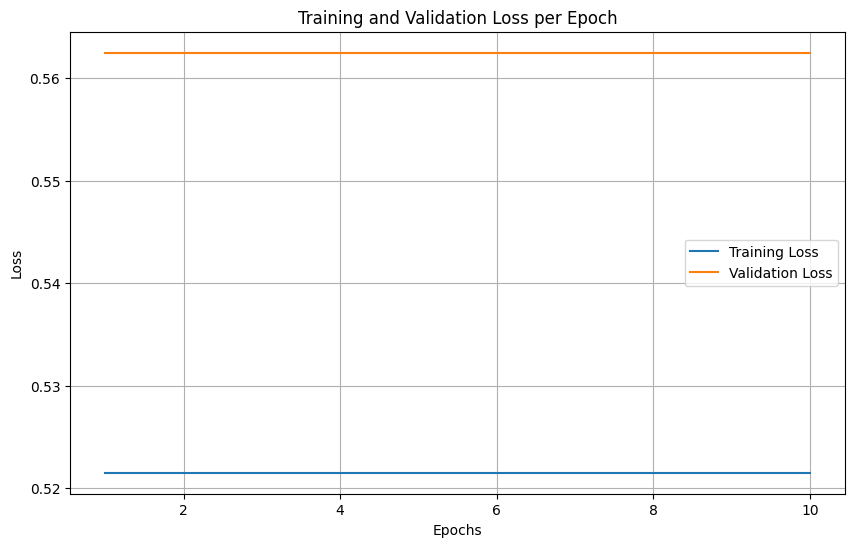

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 11), train_loss_epochs, label='Training Loss')
plt.plot(np.arange(1, 11), val_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

### Analysis

- using tfidf, the model train of 10 epochs gave a constant loss.

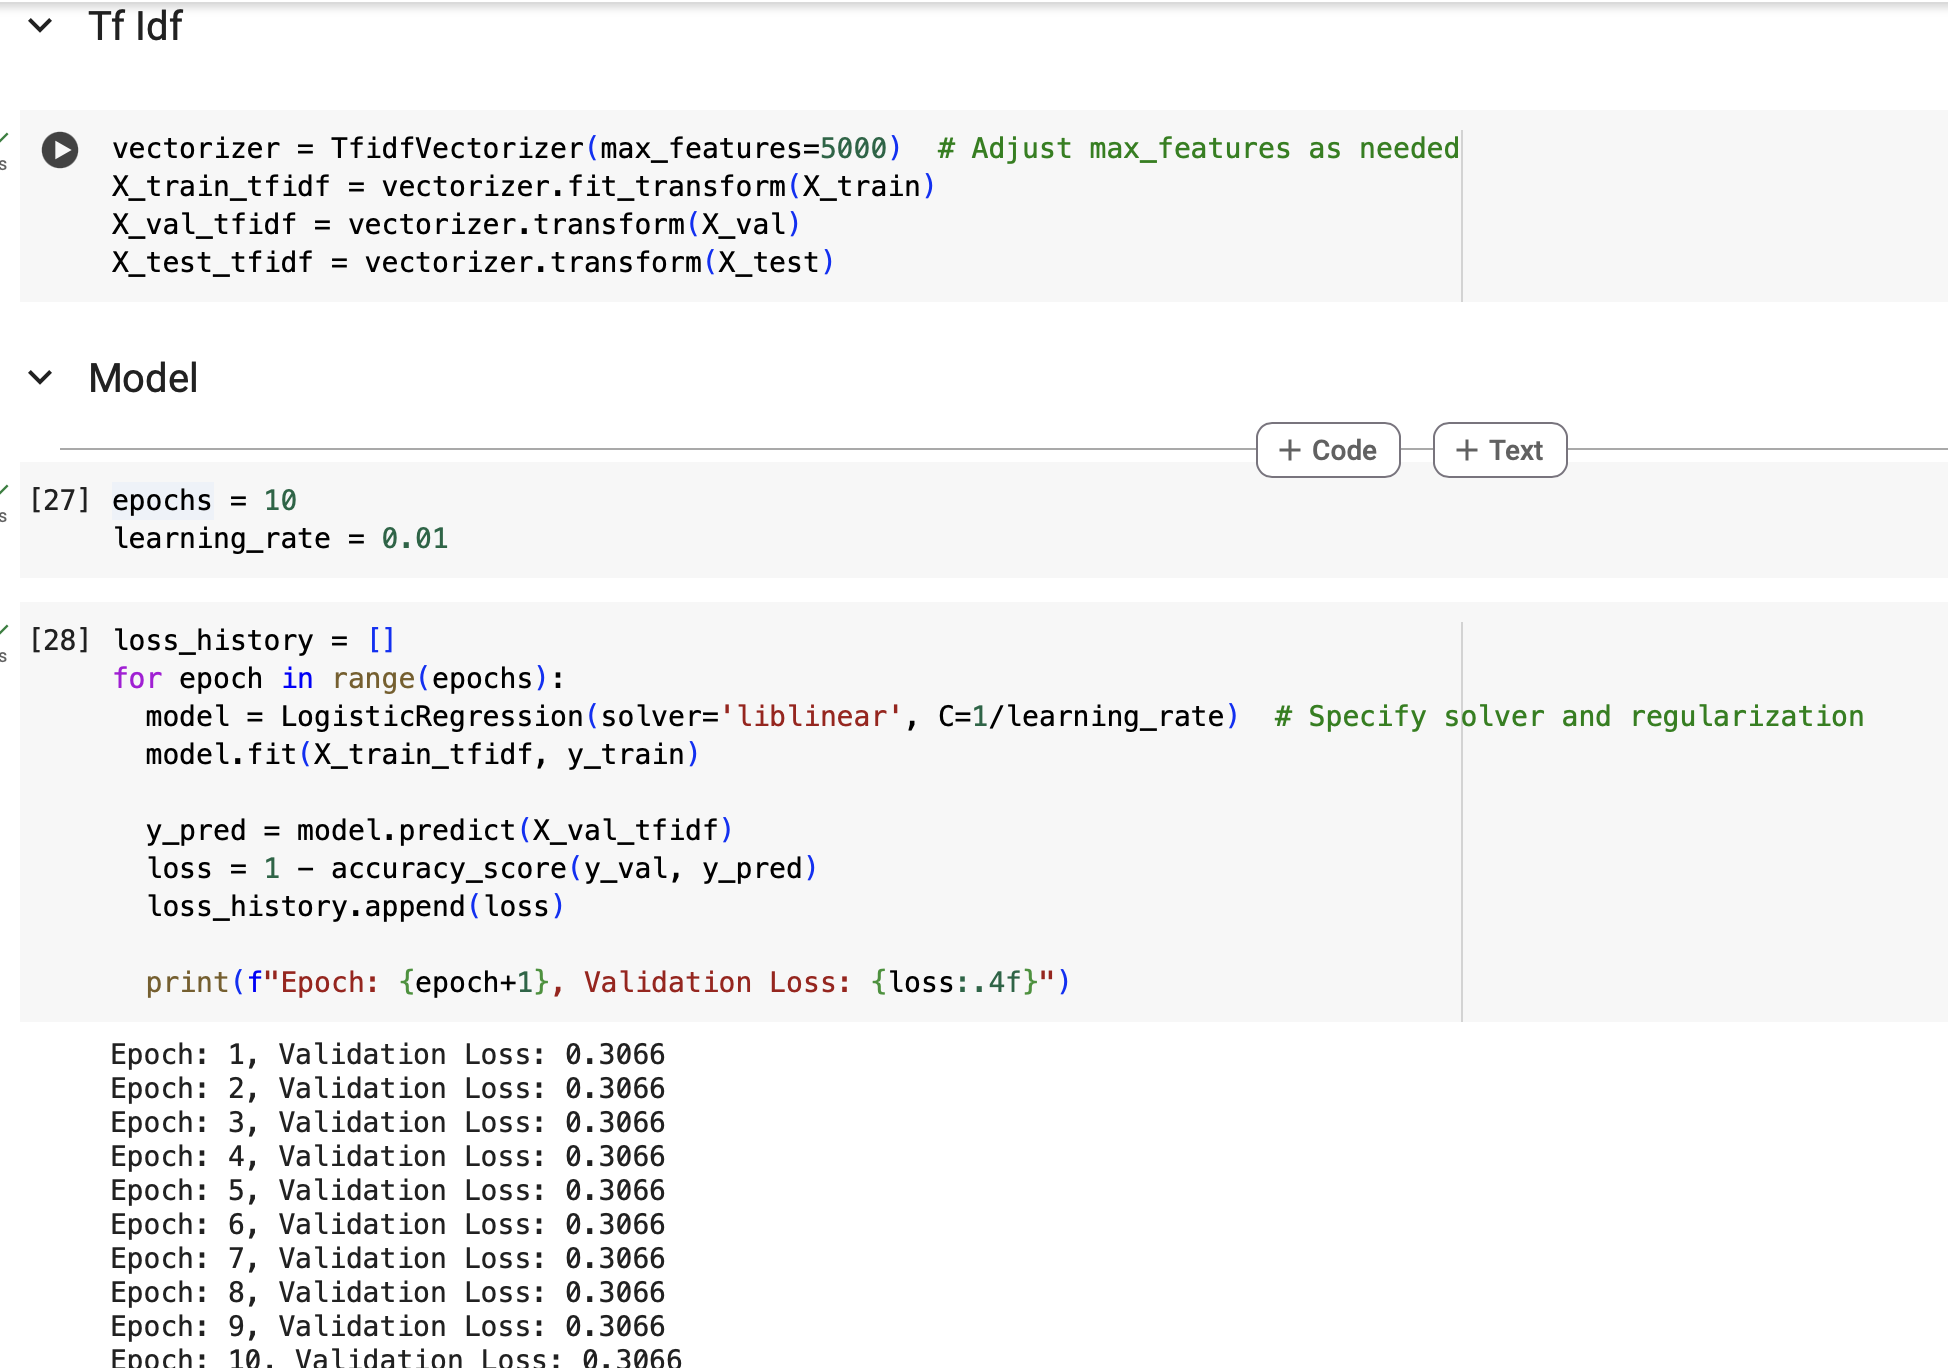
